Changing school demographics
=============================
This notebook creates a case study of how to use the NYC School data to look at questions of changing demographics and how that impacts other factors in schools.

- add a % change column to school demo that shows the 5 year change in each of the demographic fields of race/eth, poverty, ell, swd.
- map the schools with largest negative and postive change as a heat map
- calculate aggregates with this data by zip code and district
- run status to see how change in wealth impacts test scores for all students, but also for specific ethnic groups (Do Black students see the same gains as White students in schools that have an increase in % white students?)



In [2]:

import pandas as pd
#from pandas.core.window.indexers import calculate_variable_window_bounds
import geopandas as gpd
import folium
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
from IPython.display import display, HTML
from nycschools import schools, exams, ui, geo



In [3]:
df = schools.load_school_demographics()

change_cols = ['total_enrollment','asian_n', 'asian_pct', 'black_n', 'black_pct',
       'hispanic_n', 'hispanic_pct', 'white_n', 'white_pct', 'poverty_n','poverty_pct']
cols = ["dbn", "ay"] + change_cols
df = df[cols]
df = df.dropna()
df.head()



,dbn,ay,total_enrollment,asian_n,asian_pct,black_n,black_pct,hispanic_n,hispanic_pct,white_n,white_pct,poverty_n,poverty_pct
0,01M015,2016,178,14,0.079,51,0.287,105,0.590,4,0.022,152,0.854
1,01M015,2017,190,20,0.105,52,0.274,110,0.579,6,0.032,161,0.847
2,01M015,2018,174,24,0.138,48,0.276,95,0.546,6,0.034,147,0.845
3,01M015,2019,190,27,0.142,56,0.295,96,0.505,9,0.047,155,0.816
4,01M015,2020,193,26,0.135,53,0.275,102,0.528,11,0.057,158,0.819


In [ ]:
df.describe()

,ay,total_enrollment,asian_n,asian_pct,black_n,black_pct,hispanic_n,hispanic_pct,white_n,white_pct,poverty_n,poverty_pct
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,2018.025797,587.865913,95.582342,0.115959,151.899610,0.311174,238.713529,0.424937,85.969803,0.121446,435.802920,0.764572
std,1.413695,468.705727,215.232080,0.166804,166.142648,0.263531,220.579754,0.248044,176.585355,0.175990,344.157943,0.196051
min,2016.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.015000,0.000000,0.000000,2.000000,0.040000
25%,2017.000000,323.000000,6.000000,0.015000,41.000000,0.082000,90.000000,0.201000,6.000000,0.015000,236.000000,0.706000
50%,2018.000000,478.000000,19.000000,0.044000,104.000000,0.248000,182.000000,0.398000,16.000000,0.035000,357.000000,0.823000
75%,2019.000000,694.000000,83.000000,0.143000,196.000000,0.492000,313.000000,0.629000,81.000000,0.147000,528.000000,0.903000
max,2020.000000,6040.000000,3671.000000,0.944000,1493.000000,0.963000,2056.000000,1.000000,3104.000000,0.945000,3655.000000,0.960000


In [4]:
ay16 = df[df.ay == 2016].dbn
ay20 = df[df.ay == 2020].dbn

dbn_list = set(ay16).intersection(set(ay20))
data = df[df.dbn.isin(dbn_list)]
# data.ay.unique()

data_20 = data[data.ay == 2020]
data_16 = data[data.ay == 2016]

len(data_20)


1948

In [11]:
def calc_diff(row_20):
    row_16 = data[(data.dbn == row_20.dbn) & (data.ay == 2016)].iloc[0]
    for c in change_cols:
        row_20[f"{c}_change"] = row_20[c] - row_16[c]
        if row_16[c] == 0:
            row_20[f"{c}_pct_change"] = 0
            print(row_16[c], row_20[c])
        else:
            row_20[f"{c}_pct_change"] = ((row_20[c] + 1) - (row_16[c] + 1)) / (row_16[c] + 1)
    return row_20


x = data_20.sample(50).apply(calc_diff, axis=1)
x.head()
# data_20[~data_20.dbn.isin(data_16.dbn)]



0 2
0.0 0.007
0 0
0.0 0.0
0 0
0.0 0.0
0 1
0.0 0.004


,dbn,ay,total_enrollment,asian_n,asian_pct,black_n,black_pct,hispanic_n,hispanic_pct,white_n,...,hispanic_pct_change,hispanic_pct_pct_change,white_n_change,white_n_pct_change,white_pct_change,white_pct_pct_change,poverty_n_change,poverty_n_pct_change,poverty_pct_change,poverty_pct_pct_change
9779,84X460,2020,596,2,0.003,114,0.191,461,0.773,12,...,0.038,0.051694,5,0.714276,-0.008,-0.284698,311,1.517072,0.043,0.052242
1644,06M513,2020,179,2,0.011,6,0.034,128,0.715,33,...,0.067,0.103379,-12,-0.266666,-0.014,-0.070671,-24,-0.172662,0.030,0.049012
7221,28Q303,2020,371,130,0.350,20,0.054,61,0.164,140,...,-0.019,-0.103768,55,0.647058,-0.032,-0.078220,9,0.180000,-0.081,-0.337359
4920,19K224,2020,283,12,0.042,154,0.544,106,0.375,2,...,0.071,0.233476,-4,-0.666656,-0.007,-0.496454,-120,-0.312500,0.027,0.029798
5357,20K971,2020,254,113,0.445,0,0.000,110,0.433,30,...,0.048,0.124643,-1,-0.032258,0.035,0.421179,-118,-0.341040,-0.027,-0.029186


In [39]:
x.value_counts

,dbn,ay,total_enrollment,asian_n,asian_pct,black_n,black_pct,hispanic_n,hispanic_pct,white_n,...,hispanic_pct_change,hispanic_pct_pct_change,white_n_change,white_n_pct_change,white_pct_change,white_pct_pct_change,poverty_n_change,poverty_n_pct_change,poverty_pct_change,poverty_pct_pct_change
4,01M015,2020,193,26,0.135000,53,0.275000,102,0.528000,11,...,-0.062000,-0.105085,7,1.750000,0.035000,1.590909,6,0.039474,-0.035,-0.040984
9,01M019,2020,212,13,0.061000,41,0.193000,130,0.613000,17,...,-0.051000,-0.076807,2,0.133333,0.025000,0.454545,-56,-0.270531,-0.052,-0.068063
14,01M020,2020,412,102,0.248000,55,0.133000,215,0.522000,30,...,0.033000,0.067485,3,0.111111,0.023000,0.460000,-23,-0.073016,0.126,0.216123
19,01M034,2020,273,7,0.026000,104,0.381000,152,0.557000,8,...,-0.060000,-0.097245,-3,-0.272727,-0.002000,-0.064516,-73,-0.217262,0.000,0.000000
24,01M063,2020,208,6,0.029000,40,0.192000,132,0.635000,19,...,-0.010000,-0.015504,-2,-0.095238,-0.014000,-0.133333,-5,-0.030303,-0.056,-0.067879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,84X705,2020,416,3,0.007212,88,0.211538,323,0.776442,0,...,-0.010655,-0.013536,-2,-1.000000,-0.004301,-1.000000,-11,-0.026764,0.076,0.085973
9985,84X706,2020,647,0,0.000000,399,0.616692,232,0.358578,4,...,0.030048,0.091461,-1,-0.200000,-0.001022,-0.141886,63,0.132632,0.148,0.216374
9990,84X717,2020,328,4,0.012195,164,0.500000,157,0.478659,0,...,0.019031,0.041406,-2,-1.000000,-0.006211,-1.000000,15,0.054945,0.030,0.035377
9995,84X718,2020,570,5,0.008772,482,0.845614,57,0.100000,8,...,0.001996,0.020370,-1,-0.111111,-0.002299,-0.140741,24,0.054176,0.015,0.018657


In [10]:
x.isna()

,dbn,ay,total_enrollment,asian_n,asian_pct,black_n,black_pct,hispanic_n,hispanic_pct,white_n,...,hispanic_pct_change,hispanic_pct_pct_change,white_n_change,white_n_pct_change,white_pct_change,white_pct_pct_change,poverty_n_change,poverty_n_pct_change,poverty_pct_change,poverty_pct_pct_change
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
34,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
44,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:



# data = data.sort_values(by=["dbn", "ay"])
# for col in change_cols:
#     data[f"{col}_change"] = data[col].diff()
#     data[f"{col}_change_pct"] = data[col].pct_change()
# data = data[data.ay == 2020]
# data[["dbn", "school_name", "district", "boro", "ay", "poverty_pct", "poverty_pct_change", "poverty_pct_change_pct"]].sort_values("poverty_pct_change").head(20)


In [29]:
# make a map of the schools plotted by change in income
school_loc = geo.load_school_locations()
school_loc['dbn'].value_counts()

22K152    4
10X280    4
24Q311    4
02M544    4
17K138    4
         ..
84R077    1
84K362    1
06M348    1
31R047    1
29Q118    1
Name: dbn, Length: 1930, dtype: int64

In [31]:
x['dbn'].count

<bound method Series.count of 4      01M015
9      01M019
14     01M020
19     01M034
24     01M063
29     01M064
34     01M110
39     01M134
44     01M140
49     01M142
54     01M184
59     01M188
64     01M292
69     01M315
74     01M332
79     01M361
84     01M363
89     01M364
94     01M378
99     01M448
104    01M450
109    01M458
115    01M515
120    01M539
125    01M650
130    01M696
135    01M839
141    02M001
146    02M002
151    02M003
156    02M006
161    02M011
166    02M033
183    02M040
184    02M040
185    02M040
186    02M040
191    02M041
196    02M042
201    02M047
206    02M051
211    02M059
216    02M077
221    02M089
226    02M104
231    02M111
236    02M114
242    02M116
247    02M124
252    02M126
Name: dbn, dtype: object>

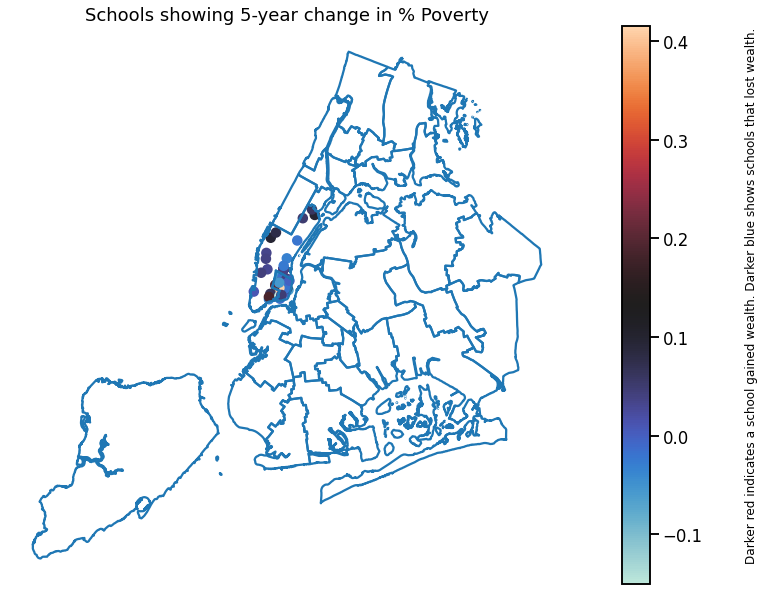

In [26]:

districts = geo.load_districts()

# merge poverty_pct_change into our location dataframe
school_loc = school_loc.merge(x[["dbn", "poverty_pct_change"]], on="dbn", how="inner")

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc.plot(ax=ax, column="poverty_pct_change", cmap="icefire", legend=True)

ax.set_title('Schools showing 5-year change in % Poverty',)
fig.suptitle('Darker red indicates a school gained wealth. Darker blue shows schools that lost wealth.', fontsize=12, x =.95, y=.5, rotation=90)
fig.tight_layout()

In [25]:
school_loc

,dbn,zip,geo_district,district,x,y,administrative_district_code,administrative_district_name,beds,borough_block_lot,...,open_date,police_precinct,primary_building_code,principal_name,principal_phone_number,principal_title,state_code,status_descriptions,geometry,poverty_pct_change
0,01M184,10002,1,1,988287,198359,1.0,COMMUNITY SCHOOL DISTRICT 01,310100010184,1.002450e+09,...,1999-06-22,7.0,M137,Iris Chiu,212-602-9700,Principal,NY,Open,POINT (-73.98544 40.71113),-0.016
1,02M051,10036,2,2,985501,216735,2.0,COMMUNITY SCHOOL DISTRICT 02,310200010051,1.010730e+09,...,1905-07-01,18.0,M338,Stephanie Lukas,212-315-7160,Principal,NY,Open,POINT (-73.99548 40.76156),0.097
2,02M114,10128,2,2,998823,223621,2.0,COMMUNITY SCHOOL DISTRICT 02,310200010114,1.015540e+09,...,1999-07-01,19.0,M114,DAVID GETZ,212-360-0114,Principal,NY,Open,POINT (-73.94738 40.78045),0.098
3,02M041,10011,2,2,984501,207221,2.0,COMMUNITY SCHOOL DISTRICT 02,310200010041,1.006060e+09,...,1958-07-01,6.0,M041,KELLY SHANNON,212-675-2756,Principal,NY,Open,POINT (-73.99909 40.73545),0.029
4,01M019,10003,1,1,988547,205239,1.0,COMMUNITY SCHOOL DISTRICT 01,310100010019,1.004530e+09,...,1956-07-01,9.0,M019,JACQUELINE FLANAGAN,212-533-5340,Principal,NY,Open,POINT (-73.98450 40.73001),-0.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,01M515,10002,1,1,988120,201607,1.0,NaN,310100011515,1.003540e+09,...,1996-06-05,7.0,M025,Rene Anaya,212-505-6366,Principal,NY,Open,POINT (-73.98604 40.72004),0.415
58,01M458,10002,1,1,986892,202472,1.0,NaN,310100011458,1.004220e+09,...,2010-07-01,5.0,M510,Patrick Reimer,212-677-8900,Principal,NY,Open,POINT (-73.99047 40.72242),0.202
59,01M134,10002,1,1,988726,199497,1.0,COMMUNITY SCHOOL DISTRICT 01,310100010134,1.002880e+09,...,1960-07-01,7.0,M134,ROBERT PERALES,212-673-4470,I.A. Principal,NY,Open,POINT (-73.98385 40.71425),0.048
60,01M034,10009,1,1,991163,203782,1.0,COMMUNITY SCHOOL DISTRICT 01,310100010034,1.003810e+09,...,1955-07-01,9.0,M034,ANGELIKI LOUKATOS,212-228-4433,Principal,NY,Open,POINT (-73.97506 40.72601),0.000


In [ ]:
#construct dataframe with just percent changes

percent = data[['total_enrollment_change_pct', 'asian_pct_change_pct', 'black_pct_change_pct',
       'hispanic_pct_change_pct', 'multi_racial_pct_change_pct',
       'white_pct_change_pct', 'swd_pct_change_pct', 'ell_pct_change_pct', 
       'poverty_pct_change_pct', 'eni_pct_change_pct']]
percent.head()



,total_enrollment_change_pct,asian_pct_change_pct,black_pct_change_pct,hispanic_pct_change_pct,multi_racial_pct_change_pct,white_pct_change_pct,swd_pct_change_pct,ell_pct_change_pct,poverty_pct_change_pct,eni_pct_change_pct
4,0.084270,0.708861,-0.041812,-0.105085,-0.705882,1.590909,-0.222997,0.626866,-0.040984,-0.029478
9,-0.217712,-0.314607,0.026596,-0.076807,7.250000,0.454545,0.206154,0.272727,-0.068063,0.193772
14,-0.237037,-0.234568,0.385417,0.067485,-0.464286,0.460000,0.013953,-0.308140,0.216123,0.125554
24,0.040000,-0.275000,0.037838,-0.015504,0.360000,-0.133333,-0.154545,-0.440000,-0.067879,0.101449
29,-0.109312,-0.396226,-0.061856,0.075444,0.125000,-0.369231,-0.195122,-0.550000,-0.047917,0.070388


In [ ]:
percent.corrwith(percent['poverty_pct_change_pct'])

total_enrollment_change_pct   -0.075905
asian_pct_change_pct          -0.032396
black_pct_change_pct           0.023532
hispanic_pct_change_pct        0.067765
multi_racial_pct_change_pct   -0.053010
white_pct_change_pct          -0.082987
swd_pct_change_pct             0.079395
ell_pct_change_pct             0.092023
poverty_pct_change_pct         1.000000
eni_pct_change_pct             0.397706
dtype: float64

In [ ]:
#clean nulls from dataset #done
#q cut function
#analyze poverty pct change's relation to other pct change columns, form groups by quartiles/quantiles (using q cut) in relation to poverty pct change
#calculate poverty change correlation vs other demographic changes, one version with all individual schools and one version with each row being a quantile/quintile
#all schools that got poorer are green and all schools richer are red on map

In [ ]:
quartiles = pd.qcut(x['poverty_pct_pct_change'],4)

In [ ]:
print(quartiles)

4      (-0.207, -0.0269]
9      (-0.207, -0.0269]
14       (0.0903, 0.288]
19     (-0.0269, 0.0903]
24     (-0.207, -0.0269]
29     (-0.207, -0.0269]
34     (-0.0269, 0.0903]
39     (-0.0269, 0.0903]
44       (0.0903, 0.288]
49     (-0.0269, 0.0903]
54     (-0.0269, 0.0903]
59       (0.0903, 0.288]
64     (-0.207, -0.0269]
69          (0.288, 1.5]
74     (-0.207, -0.0269]
79     (-0.0269, 0.0903]
84       (0.0903, 0.288]
89       (0.0903, 0.288]
94       (0.0903, 0.288]
99     (-0.0269, 0.0903]
104    (-0.0269, 0.0903]
109         (0.288, 1.5]
115         (0.288, 1.5]
120    (-0.207, -0.0269]
125    (-0.0269, 0.0903]
130    (-0.207, -0.0269]
135    (-0.0269, 0.0903]
141         (0.288, 1.5]
146    (-0.0269, 0.0903]
151         (0.288, 1.5]
156         (0.288, 1.5]
161      (0.0903, 0.288]
166    (-0.0269, 0.0903]
183         (0.288, 1.5]
184         (0.288, 1.5]
185         (0.288, 1.5]
186         (0.288, 1.5]
191         (0.288, 1.5]
196      (0.0903, 0.288]
201    (-0.207, -0.0269]


In [ ]:
#categorizes school by quartile of poverty percent change percent

x['poverty_pct_change_quartile'] = pd.qcut(x['poverty_pct_pct_change'], q = 4, labels = [4,3,2,1])

In [ ]:
x.corrwith(x['poverty_pct_change_quartile'])

ay                                  NaN
total_enrollment               0.041411
asian_n                        0.114255
asian_pct                     -0.032757
black_n                        0.425833
black_pct                      0.331320
hispanic_n                     0.269390
hispanic_pct                   0.351918
white_n                       -0.236468
white_pct                     -0.428131
poverty_n                      0.383492
poverty_pct                    0.412666
total_enrollment_change        0.247279
total_enrollment_pct_change    0.268938
asian_n_change                 0.058318
asian_n_pct_change            -0.229686
asian_pct_change              -0.067773
asian_pct_pct_change          -0.297541
black_n_change                -0.075924
black_n_pct_change             0.166917
black_pct_change              -0.200225
black_pct_pct_change          -0.006829
hispanic_n_change             -0.037624
hispanic_n_pct_change          0.025094
hispanic_pct_change           -0.158254


In [ ]:
# make a map of the schools plotted by change in income
school_loc = geo.load_school_locations()
districts = geo.load_districts()

# merge poverty_pct_change into our location dataframe
school_loc = school_loc.merge(x[["dbn", "poverty_pct_change_pct"]], on="dbn", how="inner")

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc.plot(ax=ax, column="poverty_pct_change_pct", cmap="Blues", legend=True)

ax.set_title('Schools showing 5-year % change in % Poverty',)
fig.suptitle('Darker red indicates a school gained wealth. Darker blue shows schools that lost wealth.', fontsize=12, x =.95, y=.5, rotation=90)
fig.tight_layout()

NameError: ignored